In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
from cdo import *
cdo = Cdo()
import multiprocessing

In [2]:
mdir="/orcd/nese/mhowland/001/lyqiu/GODEEP/"

In [4]:
ISOs=["ISONE","CAISO","ERCOT"]
t_name='T2'
r_name='SWDOWN'
w_name='WSPD'
h_name='Q2'
metvars=[t_name,r_name,w_name,h_name]
tzs={"PJM":"US/Eastern","CAISO":"US/Pacific","ERCOT":"US/Central","ISONE":"US/Eastern"}
scenarios=['historic','rcp85hotter','rcp45hotter']
startyear={"historic":2001,'rcp85hotter':2020,'rcp45hotter':2040}
endyear={"historic":2020,'rcp85hotter':2059,'rcp45hotter':2059}
tzs_shift={'ISONE':-5,'PJM':-5,'ERCOT':-6,'CAISO':-7}

# ISO data

## CF statistics

In [76]:
def splitmon(input,output):
    return cdo.splitmon(input=input, output=output)

def dhourmean(input):
    for im in range(1,13):
        cdo.dhourmean(input=input+'%02d.nc'%im, output=input+'%02d_dourmean.nc'%im)

def splithour(input,output):
    return cdo.splithour(input=input, output=output)

def mergetime(input,output):
    return cdo.mergetime(input=input, output=output)

def yearmean(input,output):
    return cdo.yearmean(input=input, output=output)

scenarios=["historic","rcp85hotter"]

seasons=['DJF','MAM','JJA','SON']
season_month={'DJF':[12,1,2],'MAM':[3,4,5],'JJA':[6,7,8],'SON':[9,10,11]}

for ISO in ISOs:
    for var in ['wind','solar']:
        for period in scenarios:
            sy=startyear[period]
            ey=endyear[period]
            
            # pool      = multiprocessing.Pool(20)
            # for iy in range(sy,ey+1):
            #     ifile="%s/data/%s/%s/%s/%s_gen_cf_%d.nc" % (mdir, period,var, ISO,var,iy)
            #     ofile="%s/data/%s/%s/%s/%s_gen_cf_%d_" % (mdir, period,var, ISO,var,iy)
            #     pool.apply_async(splitmon, (ifile,ofile)) #split into months
            #     pool.apply_async(dhourmean, (ofile)) #dhourmean of each month
            # pool.close()

            # pool      = multiprocessing.Pool(12)
            # for im in range(1,13):
            #     ifile="%s/data/%s/%s/%s/%s_gen_cf_????_%02d_dhourmean.nc" % (mdir, period,var, ISO,var,im)
            #     ofile="%s/data/%s/%s/%s/%s_gen_cf_annual_%02d_dhourmean.nc" % (mdir, period,var, ISO,var,im)
            #     pool.apply_async(mergetime, (ifile,ofile))
            #     o2file="%s/data/%s/%s/%s/%s_gen_cf_annual_dhourmean_%02d_" % (mdir, period,var, ISO,var,im)
            #     pool.apply_async(splithour, (ofile,o2file))
            # pool.close()

            # cdo.cleanTempDir()
            # os.system("rm %s/data/%s/%s/%s/%s_gen_cf_????_??.nc" % (mdir, period,var, ISO,var))
            # os.system("rm %s/data/%s/%s/%s/%s_gen_cf_????_??_dhourmean.nc" % (mdir, period,var, ISO,var))
            #cdo.mergetime(input="%s/data/%s/%s/%s/%s_gen_cf_annual_dhourmean_??.nc" % (mdir, period,var, ISO,var), output="%s/data/%s/%s/%s/%s_gen_cf_annual_monthly_dhourmean.nc" % (mdir, period,var, ISO,var))
            #os.system("rm %s/data/%s/%s/%s/%s_gen_cf_annual_dhourmean_??.nc" % (mdir, period,var, ISO,var))
            
            # #seasonal

            # pool      = multiprocessing.Pool(24)
            # for ih in range(24):
            #     for season in seasons:
            #         suffix="%s/data/%s/%s/%s/%s_gen_cf_annual_dhourmean_" % (mdir, period,var, ISO,var)
            #         input="-mergetime %s%02d_%02d.nc %s%02d_%02d.nc %s%02d_%02d.nc"%(suffix,season_month[season][0],ih,suffix,season_month[season][1],ih,suffix,season_month[season][2],ih)
            #         output=suffix+'%s_%02d.nc'%(season,ih)
            #         pool.apply_async(yearmean, (input,output))
            # pool.close()

            ifile="%s/data/%s/%s/%s/%s_gen_cf_annual_monthly_dhourmean.nc" % (mdir, period,var, ISO,var)
            #cdo.yearmean(input=ifile, output="%s/data/%s/%s/%s/%s_gen_cf_annualmean.nc" % (mdir, period,var, ISO,var))
            cdo.seasmean(input=ifile, output="%s/data/%s/%s/%s/%s_gen_cf_seasmean.nc" % (mdir, period,var, ISO,var))


## get cf for selected locations

In [5]:
def unstructure_grid(locations,ofile):
    line1='gridtype  = unstructured\n'
    line2='gridsize  = %d\n'%len(locations)
    line3='xvals     = '+' '.join([str(x) for x in locations['lon']])+'\n'
    line4='yvals     = '+' '.join([str(y) for y in locations['lat']])+'\n'

    with open(ofile,'w') as f:
        f.write(line1)
        f.write(line2)
        f.write(line3)
        f.write(line4)


In [114]:
ISOs=['ISONE','ERCOT','CAISO']

selected_ids={'CAISO':[91,97,120,76,21,77,43,105,47,42,53],
'ISONE':[99,18,9,20,42,86,113,10,104,34,50],
'ERCOT':[42,75,77,11,62,25,104,91,23,18,4]}

invsces=['historic','rcp85hotter']
testsces=['historic','rcp85hotter']
demandsce='mlp'
ny=3
inv_elec='baseline'
land=0
mdl='TGW'
#standar sizes
techs_RE=['wind-onshore','solar-UPV']
opdir="//orcd/nese/mhowland/001/lyqiu/GODEEP/optimization/"
cc=0

def remapnn(ifile,ofile):
    return cdo.remapnn(input=ifile, output=ofile)

for ISO in ISOs:
    for sce in invsces:
        for tech in techs_RE:
            for iid in range(1):
                eid=selected_ids[ISO][iid]
                locations=pd.read_csv('%s/Results_%s_%s/sub%dyrs_ens%d_demand_%s_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations.csv'%
                                (opdir, ISO, demandsce,ny, eid, demandsce,inv_elec,ISO, cc, land, mdl,sce, tech))
                locations=locations[locations['capacity']>1]
                gridfile='%s/Results_%s_%s/sub%dyrs_ens%d_demand_%s_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations.grid'%(opdir, ISO, demandsce,ny, eid, demandsce,inv_elec,ISO, cc, land, mdl,sce, tech)
                unstructure_grid(locations,gridfile)
                
                for scet in testsces:
                    sy=startyear[scet]
                    ey=endyear[scet]
                    for iy in range(sy,ey+1):
                        print(iy)
                        gridfile='%s/Results_%s_%s/sub%dyrs_ens%d_demand_%s_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations.grid'%(opdir, ISO, demandsce,ny, eid, demandsce,inv_elec,ISO, cc, land, mdl,scet, tech)
                        if tech=='wind-onshore':
                            ifile="/orcd/nese/mhowland/001/lyqiu/GODEEP/data/%s/wind/%s/wind_gen_cf_%d.nc"%(scet,ISO,iy)
                        elif tech=='solar-UPV':
                            ifile="/orcd/nese/mhowland/001/lyqiu/GODEEP/data/%s/solar/%s/solar_gen_cf_%d.nc"%(scet,ISO,iy)
                        ofile='%s/Results_%s_%s/sub%dyrs_ens%d_demand_%s_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations_prod_%d.nc'%(opdir, ISO, demandsce,ny, eid, demandsce,inv_elec,ISO, cc, land, mdl,scet, tech,iy)
                        cdo.remapnn(ifile,input=ifile, output=ofile,options='-P 64')
                    #pool.close()
                    #pool.join()
                #grid_xr=xr.open_dataset("%s/ISOs/%s_highres_remap.nc"%(mdir,ISO))
                
                

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


KeyboardInterrupt: 

In [7]:
ISOs=['ISONE','ERCOT','CAISO']

selected_ids={'CAISO':[91,97,120,76,21,77,43,105,47,42,53],
'ISONE':[99,18,9,20,42,86,113,10,104,34,50],
'ERCOT':[42,75,77,11,62,25,104,91,23,18,4]}

invsces=['historic','rcp85hotter']
testsces=['historic','rcp85hotter']
demandsce='mlp'
ny=3
inv_elec='baseline'
land=0
mdl='TGW'
#standar sizes
techs_RE=['wind-onshore','solar-UPV']
opdir="//orcd/nese/mhowland/001/lyqiu/GODEEP/optimization/"
cc=0

def remapnn(ifile,ofile):
    return cdo.remapnn(input=ifile, output=ofile)

for ISO in ISOs:
    for sce in invsces:
        for tech in techs_RE:
            for iid in range(0,9):
                print(iid)
                eid=selected_ids[ISO][iid]
                locations=pd.read_csv('%s/Results_%s_%s/sub%dyrs_ens%d_demand_%s_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations.csv'%
                                (opdir, ISO, demandsce,ny, eid, demandsce,inv_elec,ISO, cc, land, mdl,sce, tech))
                locations=locations[locations['capacity']>1]
                gridfile='%s/Results_%s_%s/sub%dyrs_ens%d_demand_%s_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations.grid'%(opdir, ISO, demandsce,ny, eid, demandsce,inv_elec,ISO, cc, land, mdl,sce, tech)
                unstructure_grid(locations,gridfile)
                
                for scet in testsces:
                    #gridfile='%s/Results_%s_%s/sub%dyrs_ens%d_demand_%s_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations.grid'%(opdir, ISO, demandsce,ny, eid, demandsce,inv_elec,ISO, cc, land, mdl,sce, tech)
                    if tech=='wind-onshore':
                        ifile="/orcd/nese/mhowland/001/lyqiu/GODEEP/data/%s/wind/%s/wind_gen_cf_annual_monthly_dhourmean.nc"%(scet,ISO)
                    elif tech=='solar-UPV':
                        ifile="/orcd/nese/mhowland/001/lyqiu/GODEEP/data/%s/solar/%s/solar_gen_cf_annual_monthly_dhourmean.nc"%(scet,ISO)
                    ofile='%s/Results_%s_%s/sub%dyrs_ens%d_demand_%s_%s_%s_cc_%d_landr_%d_%s_%s_%s_locations_prod_dhourmean_test_%s.nc'%(opdir, ISO, demandsce,ny, eid, demandsce,inv_elec,ISO, cc, land, mdl,sce, tech,scet)
                    cdo.remapnn(gridfile,input="-setreftime,2000-01-01,00:00,hour "+ifile, output=ofile,options='-P 64')

                
                

0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8


# figures

In [5]:
# ##library setting##
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
# from matplotlib.patch import PathPatch
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap


import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.crs import PlateCarree
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature import ShapelyFeature, OCEAN, LAKES
from cartopy.mpl.patch import geos_to_path
from cartopy.io.shapereader import Reader as ShapeReader, natural_earth
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter

import geocat.viz as gv

import cmaps
import seaborn as sns
import sys
import ast
import string


In [6]:
#colors for different things
colorpalattes={"wind-onshore":'forestgreen',"solar-UPV":"salmon","CCGT":"lightgrey","strg":"purple",
               'total':'red','trans':'black','demand':'black',
               'hist':'darkgreen','future':'darkorange','future_plus':'indianred'}

techs_RE=["wind-onshore","solar-UPV"]
techs_ge = ["wind-onshore", "solar-UPV", "CCGT"]
techs_all = ["wind-onshore", "solar-UPV", "CCGT", 'strg']
techs_all_wt=["wind-onshore", "solar-UPV", "CCGT", 'strg','trans']

#for titles and categories
tech_names={"wind-onshore":"Wind","solar-UPV":"Solar","CCGT":"Natural gas","strg":"Storage",'total':'Total','trans':'Trans.'}

##Font sizes#####
plt.rcParams['axes.labelpad'] = 4
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.titlepad'] = 5
plt.rcParams['axes.titlesize'] = 8

plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.major.pad'] = 0.5
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.pad'] = 0.5
plt.rcParams['ytick.major.size'] = 2

plt.rcParams['xtick.minor.pad'] = 0
plt.rcParams['xtick.minor.size'] = 1
plt.rcParams['ytick.minor.pad'] = 0
plt.rcParams['ytick.minor.size'] = 1

plt.rcParams['savefig.directory'] ="./figdir/"
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 100

plt.rcParams['legend.title_fontsize'] = 7
plt.rcParams['legend.fontsize'] = 6.5

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
        
#figure subtitle
cbart_fontsize=8
lonlat_fontsize=5
##map parameters

##map of cf
heatmapcmp = cmaps.BlueWhiteOrangeRed


topocmp ={'cmp':gv.truncate_colormap(cmap=cmaps.OceanLakeLandSnow, minval=0.01, maxval=1),
          'levels':np.arange(0, 2100,100),'ticks':np.arange(0, 2200, 200)}
topocmp['norm'] = BoundaryNorm(topocmp['levels'], ncolors=topocmp['cmp'].N, clip=True)

#states in ISNE
states = ["Maine", "Massachusetts","Rhode Island", "New Hampshire","Vermont","Connecticut"]

### map of farms
divfactors={"wind-onshore":8,"solar-UPV":100}
tech_units={"wind-onshore":"MW","solar-UPV":"GW"}
unitfactors={"wind-onshore":1,"solar-UPV":1000}
legendncol={"wind-onshore":2,"solar-UPV":3}

##
case_fontsize=5
commentxdel=-0.025
commentydel=-0.06

In [7]:
def setupmapbg(ax,ISO):
    if ISO=='ISONE':
        latmin=40.2;latmax=47.8;lonmin=-74;lonmax=-66.8
        latticks=[42,46]
        lonticks=[-72,-68]
    elif ISO=='ERCOT':
        latmin=25.5;latmax=37;lonmin=-107;lonmax=-93
        latticks=[26,30,34]
        lonticks=[-106,-102,-98,-94]
    elif ISO=='CAISO':
        latmin=32;latmax=42;lonmin=-125;lonmax=-114
        latticks=[34,38]
        lonticks=[-124,-120,-116]
    ax.set_extent([lonmin, lonmax, latmin, latmax])
    ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces',
                                                scale='10m', facecolor='none', edgecolor='black',
                                                linewidth=0.5, zorder=5))
    ax.coastlines(linewidth=0.3, zorder=1)
    gv.set_axes_limits_and_ticks(ax, xticks=lonticks, yticks=latticks)
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)


def setup_map_panel_ticks(ax, ir, ic, nr, nc, xlabel, ylabel):
    ax.tick_params(axis='both', right=False, top=False, left=True, bottom=True, length=2,
                   # Remove ticks on the right side
                   pad=0.5, labelsize=plt.rcParams['xtick.labelsize']-1.5)
    ax.yaxis.set_ticklabels([])
    ax.xaxis.set_ticklabels([])
    if ir == nr-1:
        gv.add_lat_lon_ticklabels(ax)
        ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
        ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))
        if ic != 0:
            ax.yaxis.set_ticklabels([])
        ax.set_xlabel(xlabel)
    else:
        ax.xaxis.set_tick_params(top=False, labeltop=False)
    if ic == 0:
        gv.add_lat_lon_ticklabels(ax)
        ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
        ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))
        if ir != nr-1:
            ax.xaxis.set_ticklabels([])
        ax.set_ylabel(ylabel)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=90, va='center')
    else:
        ax.yaxis.set_tick_params(right=False, labelright=False)


def setsubtitle(ax, title, ni=None, nrc=None, pad=plt.rcParams['axes.titlepad'], subt_fontsize=plt.rcParams['axes.titlesize']):
    if ni == None:
        if nrc == None:
            ax.set_title(f'{title}', fontsize=subt_fontsize,
                         loc='left', pad=pad, va='center')
        else:
            ir = nrc[0]
            ic = nrc[1]
            nc = nrc[3]
            ni = ir*nc+ic
            ax.set_title(f'({string.ascii_lowercase[ni]}) {
                         title}', fontsize=subt_fontsize, loc='left', pad=pad, va='center')
    else:
        ax.set_title(f'({string.ascii_lowercase[ni]}) {
                     title}', fontsize=subt_fontsize, loc='left', pad=pad, va='center')

## ISO masks
Step 1: get county information

ISONE: Six states (MA,NH,VT,ME,CT,RI)

ERCOT: 214 counties; manual filter using maps https://www.ercot.com/files/assets/2022/12/13/ERCOT-Maps_Area-by-county.jpg?

CAISO: Dowload from https://gis.data.ca.gov/documents/07c4d7253138472782716db5ff4cf62a/explore 

Step 2:use shapefile to generate netcdf mask at 0.001deg (~1km)

Step 3: remapbil to the climate data grid 

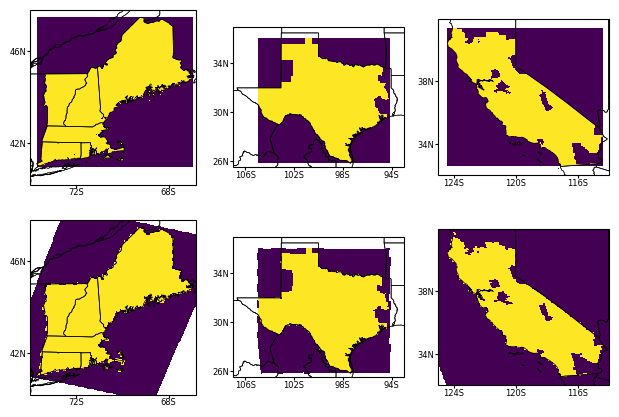

In [11]:
ISOs=["ISONE","ERCOT","CAISO"]
fig, axs = plt.subplots(2, 3, figsize=(7.5,5), subplot_kw={'projection': ccrs.PlateCarree()})

for ir in range(2):
    for ic in range(3):
        iso=ISOs[ic]
        setupmapbg(axs[ir][ic],ISOs[ic])
        if ir==0:
            data=xr.open_dataset(f"/orcd/nese/mhowland/001/lyqiu/GODEEP/ISOs/{iso}_highres.nc")['mask']
        else:
            data=xr.open_dataset(f"/orcd/nese/mhowland/001/lyqiu/GODEEP/ISOs/{iso}_highres_remap.nc")['mask']
        axs[ir][ic].pcolormesh(data.lon,data.lat,data)

## resource: mean

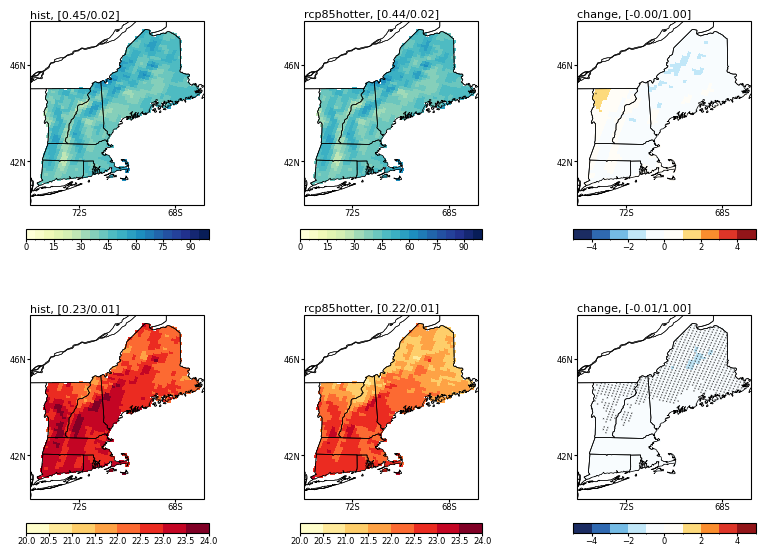

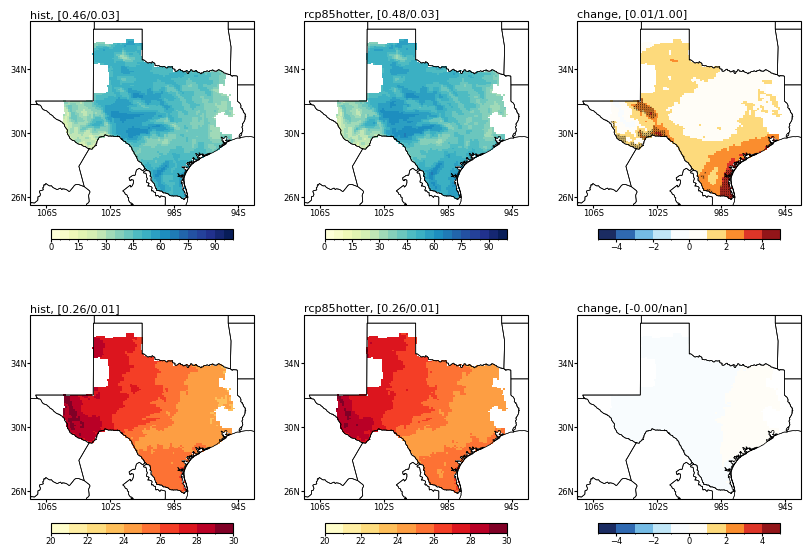

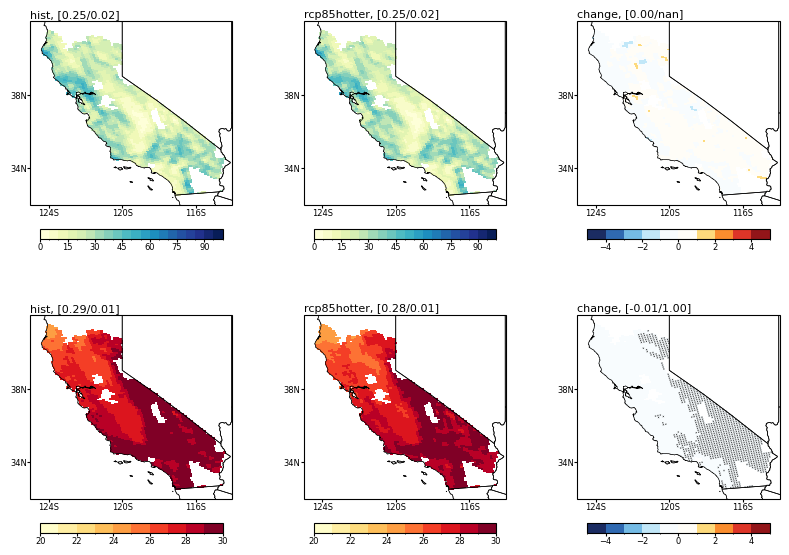

In [74]:
import scipy.stats as stats
scenarios=['historic','rcp85hotter']
resources=['wind','solar']
ISOs=["ISONE","ERCOT","CAISO"]

cmp_diff={'cmp':heatmapcmp,'levels':np.arange(-5,6,1),'ticks':np.arange(-5,6,2)}
cmp_diff['norm']=BoundaryNorm(cmp_diff['levels'],ncolors=cmp_diff['cmp'].N,clip=True)

for ISO in ISOs:
    fig,axs=plt.subplots(2,3,figsize=(10,7),subplot_kw={'projection': ccrs.PlateCarree()})
    if ISO == 'ISONE':
        cmp_windcf={'cmp':cmaps.MPL_YlGnBu,'levels':np.arange(0, 105, 5),'ticks':np.arange(0, 100, 20)}
        cmp_windcf['norm'] = BoundaryNorm(cmp_windcf['levels'], ncolors=cmp_windcf['cmp'].N, clip=True)

        cmp_solarcf={'cmp':cmaps.MPL_YlOrRd,'levels':np.arange(20, 24.5, 0.5),'ticks':np.arange(20, 24, 1)}
        cmp_solarcf['norm'] = BoundaryNorm(cmp_solarcf['levels'], ncolors=cmp_solarcf['cmp'].N, clip=True)
    elif ISO == 'ERCOT':
        cmp_windcf={'cmp':cmaps.MPL_YlGnBu,'levels':np.arange(0, 105, 5),'ticks':np.arange(0, 100, 20)}
        cmp_windcf['norm'] = BoundaryNorm(cmp_windcf['levels'], ncolors=cmp_windcf['cmp'].N, clip=True)
        cmp_solarcf={'cmp':cmaps.MPL_YlOrRd,'levels':np.arange(20, 31, 1),'ticks':np.arange(21, 31, 2)}
        cmp_solarcf['norm'] = BoundaryNorm(cmp_solarcf['levels'], ncolors=cmp_solarcf['cmp'].N, clip=True)

    for ir in range(2):
        resource=resources[ir]
        hist = xr.open_dataset("%s/data/historic/%s/%s/%s_gen_cf_annualmean.nc" % (mdir,resource,ISO,resource))['capacity_factor'].squeeze()
        future=xr.open_dataset("%s/data/%s/%s/%s/%s_gen_cf_annualmean.nc" % (mdir,scenarios[1],resource,ISO,resource))['capacity_factor'].squeeze()

        mean_hist=hist.mean(dim='Time')
        std_hist=hist.std(dim='Time')
        mean_future=future.mean(dim='Time')
        signal=mean_future-mean_hist
        SNR=signal/std_hist
        
        SNR=xr.where((SNR>1)|(SNR<-1),1,np.nan)
   
        for ic in range(3):
            setupmapbg(axs[ir][ic],ISO)

        if resource=='wind':
            cf1=axs[ir][0].pcolormesh(mean_hist['lon'],mean_hist['lat'],mean_hist*100,cmap=cmp_windcf['cmp'],norm=cmp_windcf['norm'])
            cf2=axs[ir][1].pcolormesh(mean_future['lon'],mean_future['lat'],mean_future*100,cmap=cmp_windcf['cmp'],norm=cmp_windcf['norm'])
        else:
            cf1=axs[ir][0].pcolormesh(mean_hist['lon'],mean_hist['lat'],mean_hist*100,cmap=cmp_solarcf['cmp'],norm=cmp_solarcf['norm'])
            cf2=axs[ir][1].pcolormesh(mean_future['lon'],mean_future['lat'],mean_future*100,cmap=cmp_solarcf['cmp'],norm=cmp_solarcf['norm'])
        plt.colorbar(cf1,ax=axs[ir][0],orientation='horizontal',pad=0.1,shrink=0.8) 
        plt.colorbar(cf2,ax=axs[ir][1],orientation='horizontal',pad=0.1,shrink=0.8)

        setsubtitle(axs[ir][0],"hist, [%.2f/%.2f]" % (mean_hist.mean(),std_hist.mean()))
        setsubtitle(axs[ir][1],"%s, [%.2f/%.2f]" % (scenarios[1],mean_future.mean(),std_hist.mean()))

        cf3 = axs[ir][2].pcolormesh(signal['lon'],signal['lat'],signal*100,cmap=cmp_diff['cmp'],norm=cmp_diff['norm'])
        sr=axs[ir][2].scatter(SNR['lon'],SNR['lat'],s=SNR,marker='x',c='black',linewidths=0.2)

        setsubtitle(axs[ir][2],"change, [%.2f/%.2f]" % (signal.mean(),SNR.mean()))
        if (np.isnan(SNR.mean().values)) and (np.sum(~np.isnan(SNR.values))>0):
            print('check')
        plt.colorbar(cf3,ax=axs[ir][2],orientation='horizontal',pad=0.1,shrink=0.8)    



## internal variation

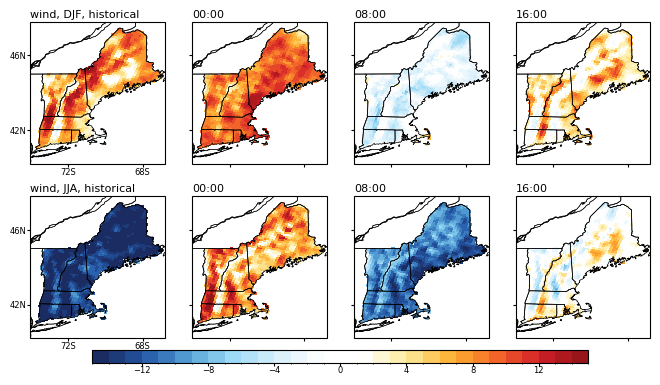

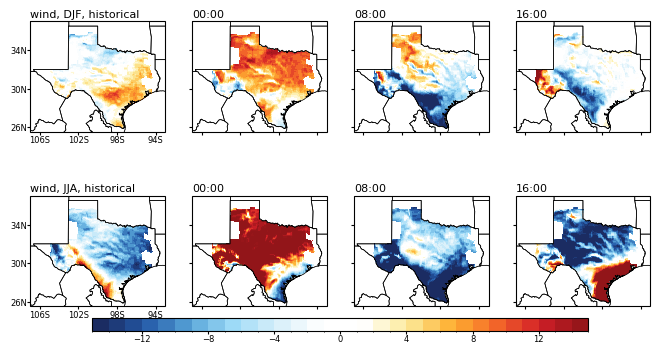

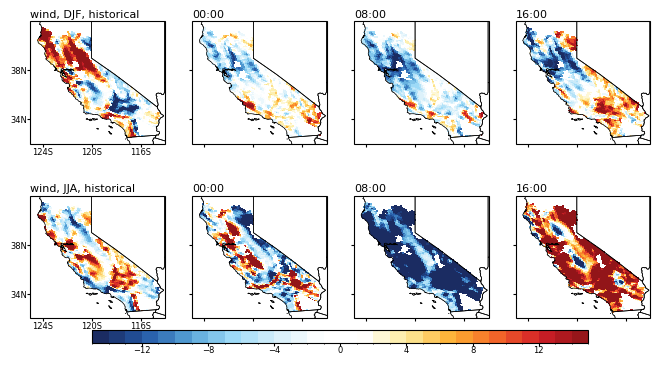

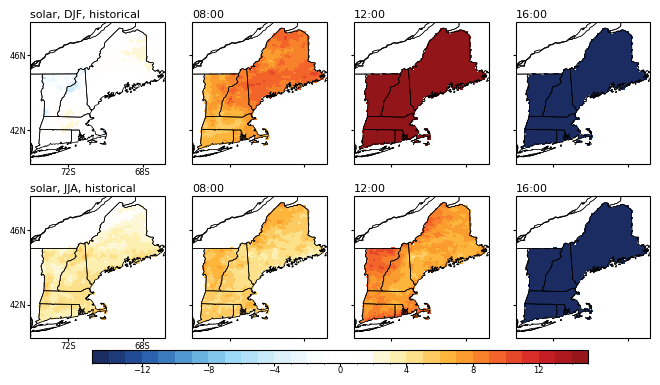

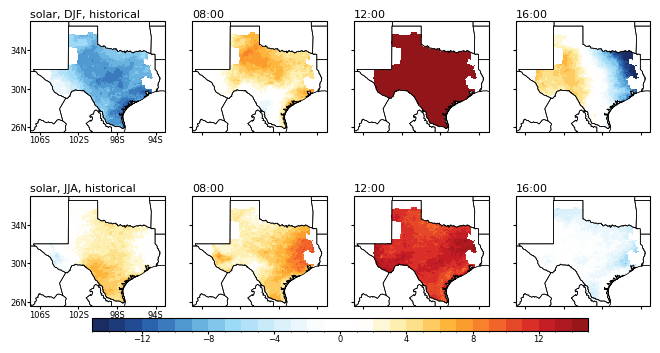

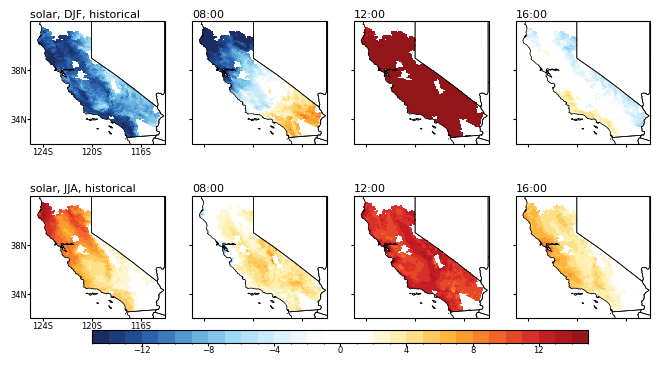

In [143]:
scenarios=['historic','rcp85hotter']
resource='wind'
ISOs=["ISONE","ERCOT","CAISO"]

seasons=['DJF','JJA']

for resource in ['wind','solar']:
    if resource=='wind':
        indexes={0:1,8:2,16:3}
        cmp_diff={'cmp':heatmapcmp,'levels':np.arange(-15,16,1),'ticks':np.arange(-2,3,1)}
        cmp_diff['norm']=BoundaryNorm(cmp_diff['levels'],ncolors=cmp_diff['cmp'].N,clip=True)
    elif resource=='solar':
        indexes={8:1,12:2,16:3}
        cmp_diff={'cmp':heatmapcmp,'levels':np.arange(-15,16,1),'ticks':np.arange(-2,3,1)}
        cmp_diff['norm']=BoundaryNorm(cmp_diff['levels'],ncolors=cmp_diff['cmp'].N,clip=True)
    for ISO in ISOs:
        fig,axs=plt.subplots(2,4,figsize=(8,5),subplot_kw={'projection': ccrs.PlateCarree()})
        seasmeandata=xr.open_dataset("%s/data/historic/%s/%s/%s_gen_cf_seasmean.nc" % (mdir,resource,ISO,resource))['capacity_factor']
        timmean=seasmeandata.mean(dim='Time')
        if resource=='solar':
            timmean=timmean*2
            seasmeandata=seasmeandata*2
        for iseason in range(2):
            season=seasons[iseason]
            seasmean=seasmeandata.isel(Time=iseason*2)
            for ih in range(24):    
                deltat=tzs_shift[ISO]
                if ih+deltat<0:
                    aindex=ih+deltat+24
                else:
                    aindex=ih+deltat  
                if aindex in indexes.keys():
                    index=indexes[aindex]
                    hist = xr.open_dataset("%s/data/historic/%s/%s/%s_gen_cf_annual_dhourmean_%s_%02d.nc" % (mdir,resource,ISO,resource,season,ih))['capacity_factor'].squeeze()
                    mean_hist=hist.mean(dim='Time')
                    # std_hist=hist.std(dim='Time')
                    mean_hist=mean_hist-seasmean
                    setupmapbg(axs[iseason][index],ISO)
                    cf3 = axs[iseason][index].pcolormesh(mean_hist['lon'],mean_hist['lat'],mean_hist*100,cmap=cmp_diff['cmp'],norm=cmp_diff['norm'])
                    # sr=axs[iseason][index].scatter(SNR['lon'],SNR['lat'],s=SNR,marker='x',c='black',linewidths=0.2)
                    #con=axs[ir][ic].scatter(conf['lon'],conf['lat'],s=conf,marker='o',c='black',edgecolors='black',linewidths=0.08)
                    setsubtitle(axs[iseason][index],"%02d:00" % (aindex))
                    setup_map_panel_ticks(axs[iseason][index], 2,2,5,5,'a','b')
            setupmapbg(axs[iseason][0],ISO)
            setsubtitle(axs[iseason][0],"%s, %s, historical" % (resource,season))
            cf3 = axs[iseason][0].pcolormesh(mean_hist['lon'],mean_hist['lat'],(seasmean-timmean)*100,cmap=cmp_diff['cmp'],norm=cmp_diff['norm'])
        plt.subplots_adjust(bottom=0.1)
        plt.colorbar(cf3,ax=axs,orientation='horizontal',pad=0.03,shrink=0.8,aspect=40)
        plt.show()



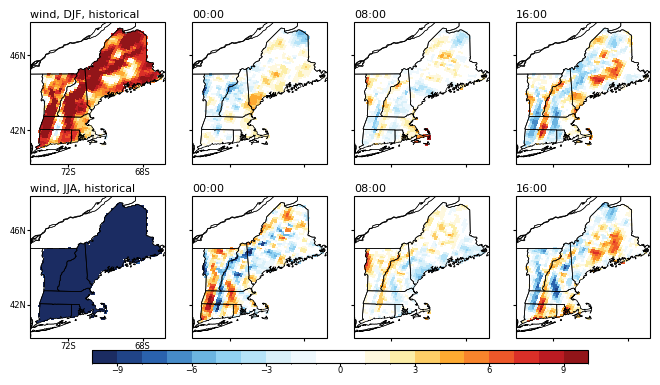

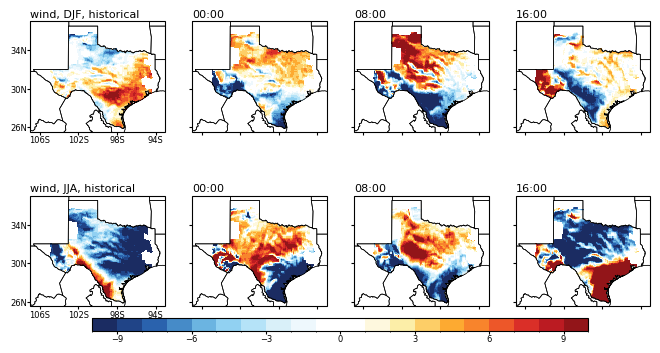

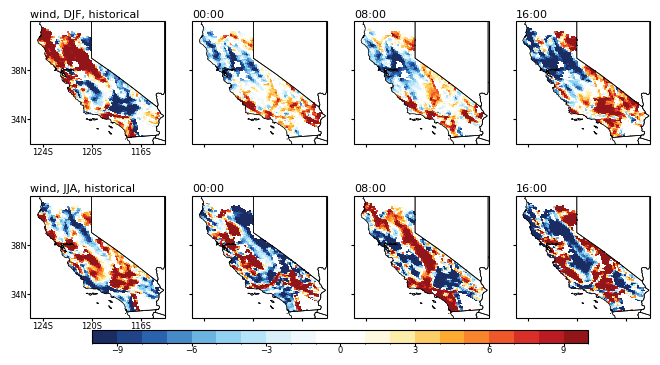

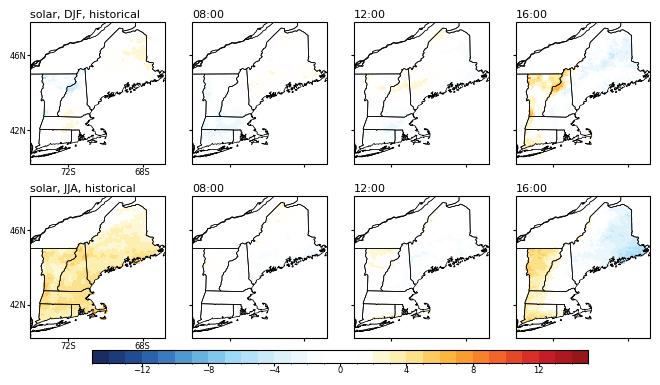

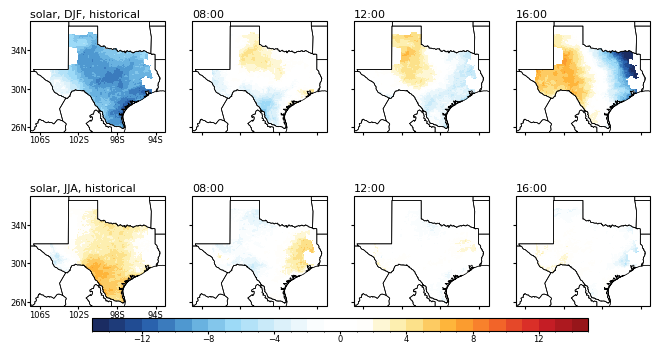

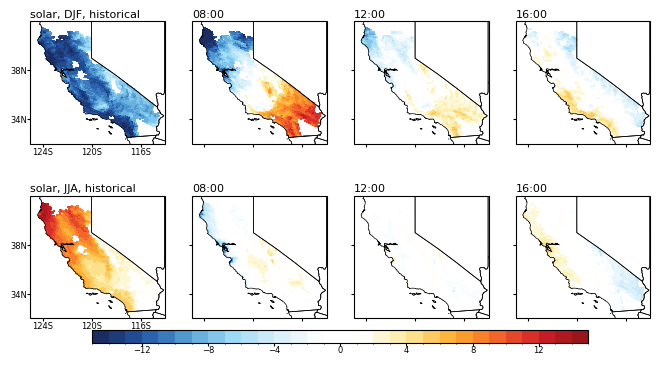

In [10]:
scenarios=['historic','rcp85hotter']
resource='wind'
ISOs=["ISONE","ERCOT","CAISO"]

seasons=['DJF','JJA']

for resource in ['wind','solar']:
    if resource=='wind':
        indexes={0:1,8:2,16:3}
        cmp_diff={'cmp':heatmapcmp,'levels':np.arange(-10,11,1),'ticks':np.arange(-2,3,1)}
        cmp_diff['norm']=BoundaryNorm(cmp_diff['levels'],ncolors=cmp_diff['cmp'].N,clip=True)
    elif resource=='solar':
        indexes={8:1,12:2,16:3}
        cmp_diff={'cmp':heatmapcmp,'levels':np.arange(-15,16,1),'ticks':np.arange(-2,3,1)}
        cmp_diff['norm']=BoundaryNorm(cmp_diff['levels'],ncolors=cmp_diff['cmp'].N,clip=True)
    for ISO in ISOs:
        fig,axs=plt.subplots(2,4,figsize=(8,5),subplot_kw={'projection': ccrs.PlateCarree()})
        seasmeandata=xr.open_dataset("%s/data/historic/%s/%s/%s_gen_cf_seasmean.nc" % (mdir,resource,ISO,resource))['capacity_factor']
        timmean=seasmeandata.mean(dim='Time')
        if resource=='solar':
            timmean=timmean*2
            seasmeandata=seasmeandata*2
        for iseason in range(2):
            season=seasons[iseason]
            seasmean=seasmeandata.isel(Time=iseason*2)
            for ih in range(24):    
                deltat=tzs_shift[ISO]
                if ih+deltat<0:
                    aindex=ih+deltat+24
                else:
                    aindex=ih+deltat  
                if aindex in indexes.keys():
                    index=indexes[aindex]
                    hist = xr.open_dataset("%s/data/historic/%s/%s/%s_gen_cf_annual_dhourmean_%s_%02d.nc" % (mdir,resource,ISO,resource,season,ih))['capacity_factor'].squeeze()
                    mean_hist=hist.mean(dim='Time')
                    mean_hist=mean_hist-seasmean
                    # std_hist=hist.std(dim='Time')
                    fldmean=mean_hist.mean()
                    mean_hist=mean_hist-fldmean
                    setupmapbg(axs[iseason][index],ISO)
                    cf3 = axs[iseason][index].pcolormesh(mean_hist['lon'],mean_hist['lat'],mean_hist*100,cmap=cmp_diff['cmp'],norm=cmp_diff['norm'])
                    # sr=axs[iseason][index].scatter(SNR['lon'],SNR['lat'],s=SNR,marker='x',c='black',linewidths=0.2)
                    #con=axs[ir][ic].scatter(conf['lon'],conf['lat'],s=conf,marker='o',c='black',edgecolors='black',linewidths=0.08)
                    setsubtitle(axs[iseason][index],"%02d:00" % (aindex))
                    setup_map_panel_ticks(axs[iseason][index], 2,2,5,5,'a','b')
            setupmapbg(axs[iseason][0],ISO)
            setsubtitle(axs[iseason][0],"%s, %s, historical" % (resource,season))
            cf3 = axs[iseason][0].pcolormesh(mean_hist['lon'],mean_hist['lat'],(seasmean-timmean)*100,cmap=cmp_diff['cmp'],norm=cmp_diff['norm'])
        plt.subplots_adjust(bottom=0.1)
        plt.colorbar(cf3,ax=axs,orientation='horizontal',pad=0.03,shrink=0.8,aspect=40)
        plt.show()



## change

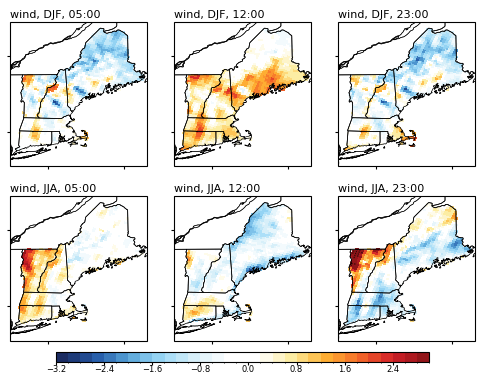

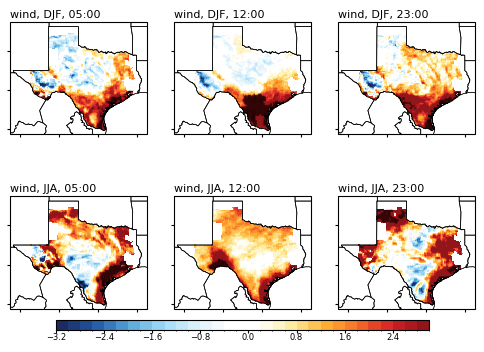

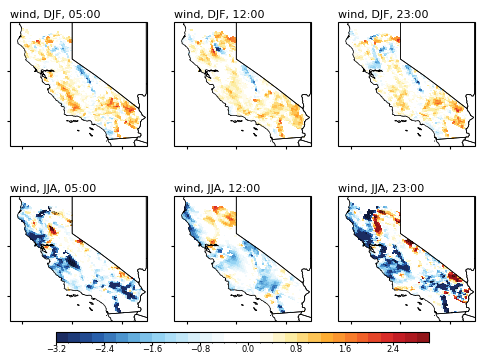

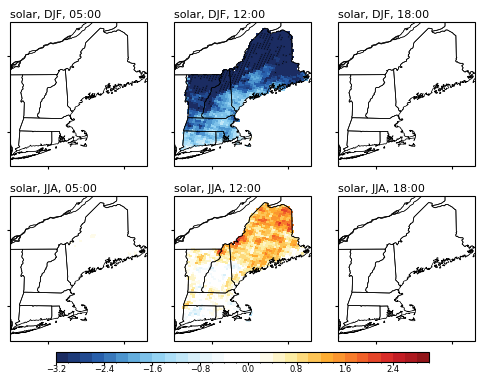

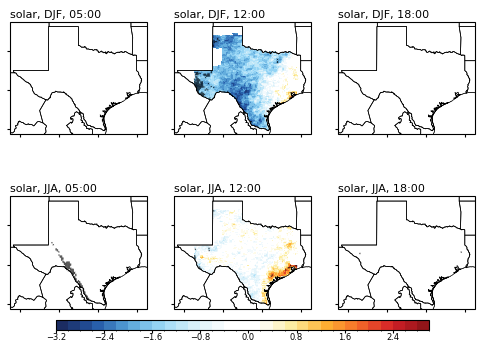

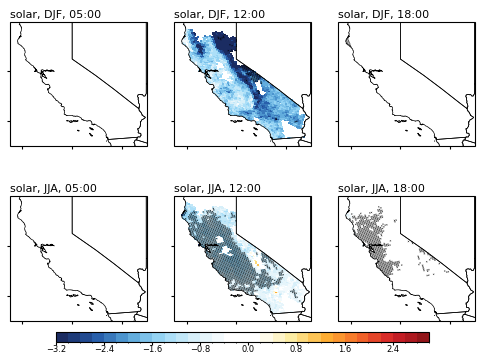

In [10]:
scenarios=['historic','rcp85hotter']

ISOs=["ISONE","ERCOT","CAISO"]
cmp_diff={'cmp':heatmapcmp,'levels':np.arange(-3.2,3.2,0.2),'ticks':np.arange(-2,3,1)}
cmp_diff['norm']=BoundaryNorm(cmp_diff['levels'],ncolors=cmp_diff['cmp'].N,clip=True)
seasons=['DJF','JJA']
indexes={0:0,4:1,8:2,12:3,16:4,20:5}
indexes={0:0,8:1,16:2}

for resource in ['wind','solar']:
    if resource=='wind':
        indexes={5:0,12:1,23:2}
    elif resource=='solar':
        indexes={5:0,12:1,18:2}    
    for ISO in ISOs:
        fig,axs=plt.subplots(2,3,figsize=(6,5),subplot_kw={'projection': ccrs.PlateCarree()})
        for iseason in range(2):
            season=seasons[iseason]
            for ih in range(24):    
                deltat=tzs_shift[ISO]
                if ih+deltat<0:
                    aindex=ih+deltat+24
                else:
                    aindex=ih+deltat  
                if aindex in indexes.keys():
                    index=indexes[aindex]
                    hist = xr.open_dataset("%s/data/historic/%s/%s/%s_gen_cf_annual_dhourmean_%s_%02d.nc" % (mdir,resource,ISO,resource,season,ih))['capacity_factor'].squeeze()
                    future=xr.open_dataset("%s/data/%s/%s/%s/%s_gen_cf_annual_dhourmean_%s_%02d.nc" % (mdir,scenarios[1],resource,ISO,resource,season,ih))['capacity_factor'].squeeze()
                    mean_hist=hist.mean(dim='Time')
                    std_hist=hist.std(dim='Time')
                    mean_future=future.mean(dim='Time')
                    signal=mean_future-mean_hist
                    SNR=signal/std_hist
                    SNR=xr.where((SNR>1)|(SNR<-1),1,np.nan)
                    setupmapbg(axs[iseason][index],ISO)
                    cf3 = axs[iseason][index].pcolormesh(signal['lon'],signal['lat'],signal*100,cmap=cmp_diff['cmp'],norm=cmp_diff['norm'])
                    sr=axs[iseason][index].scatter(SNR['lon'],SNR['lat'],s=SNR,marker='x',c='black',linewidths=0.2)
                    #con=axs[ir][ic].scatter(conf['lon'],conf['lat'],s=conf,marker='o',c='black',edgecolors='black',linewidths=0.08)
                    setsubtitle(axs[iseason][index],"%s, %s, %02d:00" % (resource,season,aindex))
                    setup_map_panel_ticks(axs[iseason][index], 2,2,5,5,'a','b')
        plt.subplots_adjust(bottom=0.1)
        plt.colorbar(cf3,ax=axs,orientation='horizontal',pad=0.03,shrink=0.8,aspect=40)
        plt.show()



/home/lyqiu/miniconda3/envs/plot/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  result = super().scatter(*args, **kwargs)
/home/lyqiu/miniconda3/envs/plot/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  result = super().scatter(*args, **kwargs)
/home/lyqiu/miniconda3/envs/plot/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  result = super().scatter(*args, **kwargs)
/home/lyqiu/mini

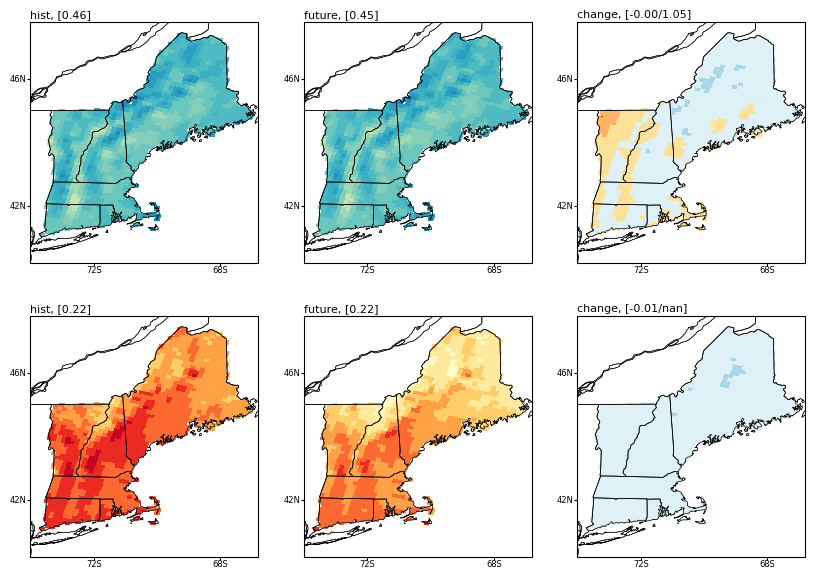

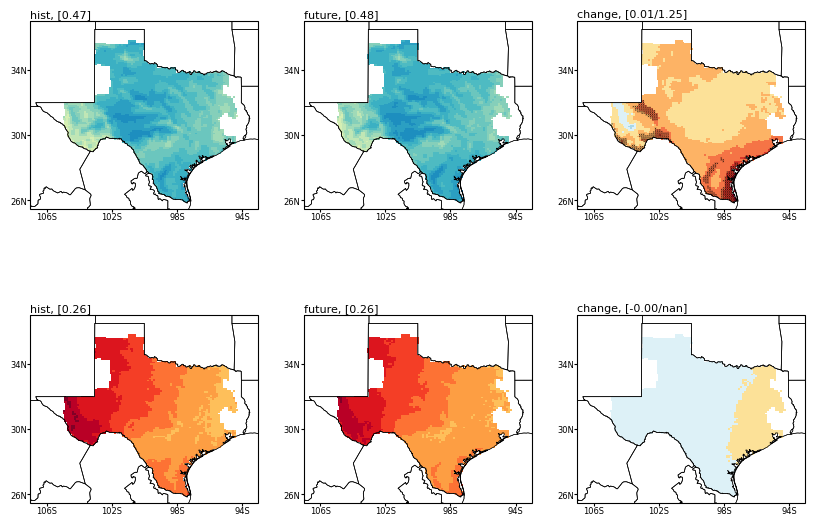

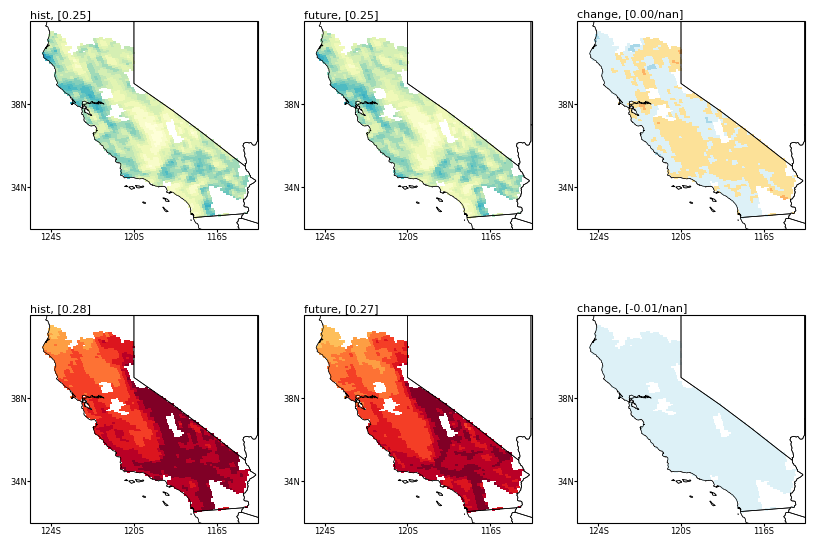

In [ ]:
import scipy.stats as stats

scenarios=['historic','rcp85hotter']
resources=['wind','solar']
ISOs=["ISONE","ERCOT","CAISO"]
for ISO in ISOs:
    fig,axs=plt.subplots(2,3,figsize=(10,7),subplot_kw={'projection': ccrs.PlateCarree()})
    if ISO == 'ISONE':
        cmp_windcf={'cmp':cmaps.MPL_YlGnBu,'levels':np.arange(0, 105, 5),'ticks':np.arange(0, 100, 20)}
        cmp_windcf['norm'] = BoundaryNorm(cmp_windcf['levels'], ncolors=cmp_windcf['cmp'].N, clip=True)

        cmp_solarcf={'cmp':cmaps.MPL_YlOrRd,'levels':np.arange(20, 24.5, 0.5),'ticks':np.arange(20, 24, 1)}
        cmp_solarcf['norm'] = BoundaryNorm(cmp_solarcf['levels'], ncolors=cmp_solarcf['cmp'].N, clip=True)
        
        cmp_diff={'cmp':heatmapcmp,'levels':np.arange(-5,6,1),'ticks':np.arange(-5,6,2)}
        cmp_diff['norm']=BoundaryNorm(cmp_diff['levels'],ncolors=cmp_diff['cmp'].N,clip=True)
    elif ISO == 'ERCOT':
        cmp_windcf={'cmp':cmaps.MPL_YlGnBu,'levels':np.arange(0, 105, 5),'ticks':np.arange(0, 100, 20)}
        cmp_windcf['norm'] = BoundaryNorm(cmp_windcf['levels'], ncolors=cmp_windcf['cmp'].N, clip=True)
        cmp_solarcf={'cmp':cmaps.MPL_YlOrRd,'levels':np.arange(20, 31, 1),'ticks':np.arange(21, 31, 2)}
        cmp_solarcf['norm'] = BoundaryNorm(cmp_solarcf['levels'], ncolors=cmp_solarcf['cmp'].N, clip=True)
        
        cmp_diff={'cmp':heatmapcmp,'levels':np.arange(-5,6,1),'ticks':np.arange(-5,6,2)}
        cmp_diff['norm']=BoundaryNorm(cmp_diff['levels'],ncolors=cmp_diff['cmp'].N,clip=True) 

    for ir in range(2):
        resource=resources[ir]
        hist = xr.open_dataset("%s/data/historic/%s/%s/%s_gen_cf_annualmean.nc" % (mdir,resource,ISO,resource))['capacity_factor'].squeeze()
        future=xr.open_dataset("%s/data/%s/%s/%s/%s_gen_cf_annualmean.nc" % (mdir,scenarios[1],resource,ISO,resource))['capacity_factor'].squeeze()

        mean_hist=hist.mean(dim='Time')
        std_hist=hist.std(dim='Time')
        mean_future=future.mean(dim='Time')
        signal=mean_future-mean_hist

        #N_hist=hist.count(dim='Time')
        #chi2_lower=stats.chi2.ppf(0.025,N_hist-1)
        #chi2_upper=stats.chi2.ppf(0.975,N_hist-1)

        # std_ci_lower=np.sqrt((N_hist-1)*std_hist**2/chi2_upper)
        # std_ci_upper=np.sqrt((N_hist-1)*std_hist**2/chi2_lower)

        # t_crit=stats.t.ppf(0.975,N_hist-1)
        # signal_ci_lower=signal-t_crit*std_ci_upper/np.sqrt(N_hist)
        # signal_ci_upper=signal+t_crit*std_ci_upper/np.sqrt(N_hist)

        SNR=signal/std_hist
        
        SNR=xr.where((SNR>1)|(SNR<-1),1,np.nan)
        #snr_uncertainty=SNR * np.sqrt((std_ci_upper - std_ci_lower) / std_hist)

        # conf=signal_ci_lower>std_ci_upper
        # conf=conf.astype(int)       
        for ic in range(3):
            setupmapbg(axs[ir][ic],ISO)

        if resource=='wind':
            cf1=axs[ir][0].pcolormesh(mean_hist['lon'],mean_hist['lat'],mean_hist*100,cmap=cmp_windcf['cmp'],norm=cmp_windcf['norm'])
            cf2=axs[ir][1].pcolormesh(mean_future['lon'],mean_future['lat'],mean_future*100,cmap=cmp_windcf['cmp'],norm=cmp_windcf['norm'])
        else:
            cf1=axs[ir][0].pcolormesh(mean_hist['lon'],mean_hist['lat'],mean_hist*100,cmap=cmp_solarcf['cmp'],norm=cmp_solarcf['norm'])
            cf2=axs[ir][1].pcolormesh(mean_future['lon'],mean_future['lat'],mean_future*100,cmap=cmp_solarcf['cmp'],norm=cmp_solarcf['norm'])
        plt.colorbar(cf1,ax=axs[ir][0],orientation='horizontal',pad=0.1,shrink=0.8) 
        plt.colorbar(cf2,ax=axs[ir][1],orientation='horizontal',pad=0.1,shrink=0.8)

        setsubtitle(axs[ir][0],"hist, [%.2f/%.2f]" % (mean_hist.mean(),std_hist.mean()))
        setsubtitle(axs[ir][1],"%s, [%.2f/%.2f]" % (scenarios[1],mean_future.mean(),std_hist.mean()))

        cf3 = axs[ir][2].pcolormesh(signal['lon'],signal['lat'],signal*100,cmap=cmp_diff['cmp'],norm=cmp_diff['norm'])
        sr=axs[ir][2].scatter(SNR['lon'],SNR['lat'],s=SNR,marker='x',c='black',edgecolors='black',linewidths=0.2)
        #con=axs[ir][ic].scatter(conf['lon'],conf['lat'],s=conf,marker='o',c='black',edgecolors='black',linewidths=0.08)

        setsubtitle(axs[ir][2],"change, [%.2f/%.2f]" % (signal.mean(),SNR.mean()))
        if (np.isnan(SNR.mean().values)) and (np.sum(~np.isnan(SNR.values))>0):
            print('check')
        plt.colorbar(cf3,ax=axs[ir][2],orientation='horizontal',pad=0.1,shrink=0.8)    

